# Transfer Learning - Extraction Classification of Flooding and Regular States

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import Model

## 1. Loading of the VGG16 Model and Preparing for Training of Transfer Learning

In [2]:
vgg_model = tf.keras.applications.vgg16.VGG16()

In [3]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [4]:
for layer in model.layers:
    layer.trainable = False
#Setting the network to not trainable so, training of would not be necessary for this part

In [5]:
model.add(layers.Dense(2))
#adding last layer to ensure two outputs

## 2. Model Compilation/ Definition of  the Optimizer Type, Learning Rate and Loss Function

In [6]:
# loss and optimizer
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate = 0.01)
metrics = [keras.metrics.BinaryAccuracy()]

model.compile(optimizer= optim, loss = loss, metrics = metrics)

## 3. Loading Sample Images by the Keras Function image_dataset_from_directory 

In [7]:
names = ['Flooding', 'Regular_State']

In [8]:
training_batches =tf.keras.preprocessing.image_dataset_from_directory(
    ('C:/Users/train'), 
    class_names=names, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True,label_mode='int'
)

Found 2364 files belonging to 2 classes.


In [9]:
testing_batches =tf.keras.preprocessing.image_dataset_from_directory(
    ('C:/Users/test'), 
    class_names=names, color_mode='rgb', batch_size=32, image_size=(224,
    224), shuffle=False, label_mode =  'categorical' 
)

Found 1013 files belonging to 2 classes.


['Flooding', 'Regular_State']


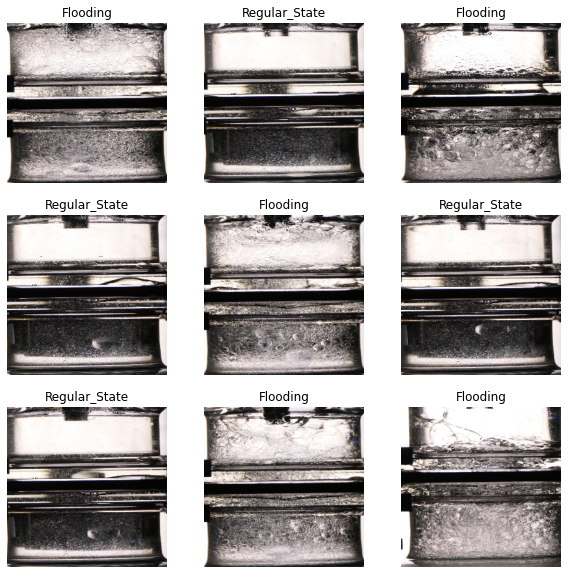

In [10]:
class_names = training_batches.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_batches.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
#display example pictures

## 4. Preprocessing and Rescaling Images for the VGG16 Input Format 

In [11]:
# allowing VGG16 to preprocess input
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [12]:
# generate batches of tensor image data and later with  real-time data augmentation
train_gen = keras.preprocessing.image.ImageDataGenerator(
          preprocessing_function = preprocess_input,
          rescale = 1.0/255)

test_gen = keras.preprocessing.image.ImageDataGenerator(
          preprocessing_function = preprocess_input,
          rescale = 1.0/255)


In [13]:
training_batches = train_gen.flow_from_directory(
    ('C:/Users/train'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    classes = names
)
#change of directory is required

Found 2364 images belonging to 2 classes.


In [14]:
testing_batches = train_gen.flow_from_directory(
    ('C:/Users/test'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=False,
    seed=42,
    classes = names
)
#change of directory is required

Found 1013 images belonging to 2 classes.


## 5. Model Fitting with Early Stopping Criterion

In [15]:
epochs = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta= 0.001,
    patience = 3,
    verbose = 2)

history = model.fit(training_batches, validation_data = testing_batches, callbacks = [early_stopping], epochs = epochs, verbose = 1 )

Epoch 1/10
74/74 [==============================] - 551s 7s/step - loss: 0.5198 - binary_accuracy: 0.9040 - val_loss: 1.6048 - val_binary_accuracy: 0.6125
Epoch 2/10
74/74 [==============================] - 575s 8s/step - loss: 0.0375 - binary_accuracy: 0.9915 - val_loss: 0.8467 - val_binary_accuracy: 0.6022
Epoch 3/10
74/74 [==============================] - 576s 8s/step - loss: 0.0193 - binary_accuracy: 0.9945 - val_loss: 0.8396 - val_binary_accuracy: 0.6313
Epoch 4/10
74/74 [==============================] - 572s 8s/step - loss: 0.0122 - binary_accuracy: 0.9966 - val_loss: 0.3851 - val_binary_accuracy: 0.8327
Epoch 5/10
74/74 [==============================] - 571s 8s/step - loss: 0.0060 - binary_accuracy: 0.9987 - val_loss: 0.3400 - val_binary_accuracy: 0.8559
Epoch 6/10
74/74 [==============================] - 610s 8s/step - loss: 0.0040 - binary_accuracy: 0.9998 - val_loss: 0.3168 - val_binary_accuracy: 0.8682
Epoch 7/10
74/74 [==============================] - 587s 8s/step - los

## 6. Model Analysis with Confusion Matrix / Precision, Recall

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
#Confusion Matrix and Classification Report
Y_pred = model.predict(testing_batches)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testing_batches.classes, y_pred))
print('Classification Report')
target_names = ['Flooding', 'Regular_State']
print(classification_report(testing_batches.classes, y_pred, target_names=target_names))

Confusion Matrix
[[510   3]
 [ 94 406]]
Classification Report
               precision    recall  f1-score   support

     Flooding       0.84      0.99      0.91       513
Regular_State       0.99      0.81      0.89       500

     accuracy                           0.90      1013
    macro avg       0.92      0.90      0.90      1013
 weighted avg       0.92      0.90      0.90      1013



## 7. Model Evaluation on a Sample Image

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

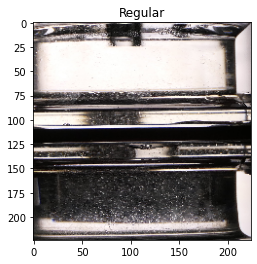

In [18]:
image = load_img('C:/Users/test/Regular_State/normalzustand007797.png', target_size=(224, 224))
plt.imshow(image)
plt.title('Regular')
plt.show()

In [19]:
image = img_to_array(image)
image = image.reshape((1, 224, 224, 3))
image = preprocess_input(image)

In [20]:
#Predict classes
pred = int(np.argmax(model.predict(image), axis=-1))

In [21]:
print('Predicted image is:', names[pred])
print('True label is: Regular_State')

Predicted image is: Regular_State
True label is: Regular_State


## 8. Plots of Training/Validation and Accuracy/Loss Values

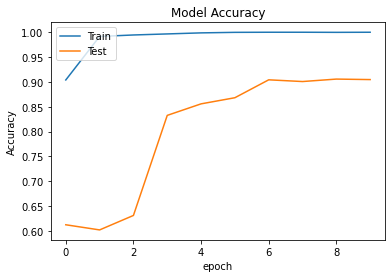

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

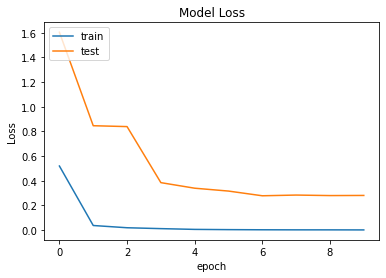

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 9. Loading the VGG16 Model and Preprocessing Images for Data Augmentation

In [24]:
# allowing VGG16 to preprocess input
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [25]:
# generate batches of tensor image data with real-time data augmentation
train_gen = keras.preprocessing.image.ImageDataGenerator(
          preprocessing_function = preprocess_input,
          rescale = 1.0/255,
          rotation_range=10, # rotation
          zoom_range=0.2, # zoom
          )


        
test_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale = 1.0/255)

                                                        

In [26]:
 names = ['Flooding', 'Regular_State']

In [27]:
train_batches = train_gen.flow_from_directory(
    ('C:/Users/train'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    classes = names
)
#change of directory is required

Found 2364 images belonging to 2 classes.


In [36]:
test_batches = test_gen.flow_from_directory(
    ('C:/Users/test'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=False, #No shuffling
    seed=42,
    classes = names
)
#change of directory is required

Found 1013 images belonging to 2 classes.


## 10. Model Fitting with Early Stopping Criterion for Augmented Dataset

In [29]:
epochs = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta= 0.001,
    patience = 3,
    verbose = 2)

history2 = model.fit(train_batches, validation_data = test_batches, callbacks = [early_stopping], epochs = epochs, verbose = 2 )

Epoch 1/10
74/74 - 713s - loss: 0.0411 - binary_accuracy: 0.9852 - val_loss: 1.5715 - val_binary_accuracy: 0.6150
Epoch 2/10
74/74 - 761s - loss: 0.0123 - binary_accuracy: 0.9958 - val_loss: 0.6772 - val_binary_accuracy: 0.6885
Epoch 3/10
74/74 - 797s - loss: 0.0062 - binary_accuracy: 0.9981 - val_loss: 0.2377 - val_binary_accuracy: 0.8914
Epoch 4/10
74/74 - 708s - loss: 0.0076 - binary_accuracy: 0.9981 - val_loss: 0.2471 - val_binary_accuracy: 0.9082
Epoch 5/10
74/74 - 749s - loss: 0.0030 - binary_accuracy: 0.9998 - val_loss: 0.2226 - val_binary_accuracy: 0.9141
Epoch 6/10
74/74 - 758s - loss: 0.0022 - binary_accuracy: 0.9998 - val_loss: 0.2759 - val_binary_accuracy: 0.8648
Epoch 7/10
74/74 - 723s - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 0.2733 - val_binary_accuracy: 0.8657
Epoch 8/10
74/74 - 672s - loss: 0.0026 - binary_accuracy: 0.9996 - val_loss: 0.3423 - val_binary_accuracy: 0.8495
Epoch 00008: early stopping


##  11. Model Analysis with Confusion Matrix / Precision, Recall for Augmented Dataset

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix and Classification Report
Y_pred = model.predict(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_batches.classes, y_pred))
print('Classification Report')
target_names = ['Flooding', 'Regular_State']
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

Confusion Matrix
[[513   0]
 [144 356]]
Classification Report
               precision    recall  f1-score   support

     Flooding       0.78      1.00      0.88       513
Regular_State       1.00      0.71      0.83       500

     accuracy                           0.86      1013
    macro avg       0.89      0.86      0.85      1013
 weighted avg       0.89      0.86      0.85      1013



## 12. Plots of Training/Validation and Accuracy/Loss Values for Augmented Dataset

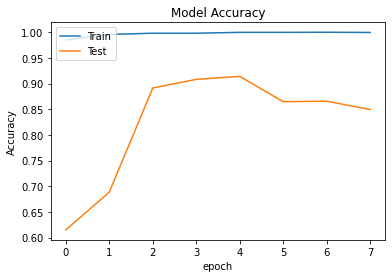

In [31]:
# Plot training & validation accuracy values
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

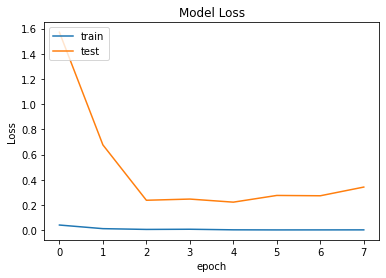

In [32]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 13. Model Evaluation on a Sample Image

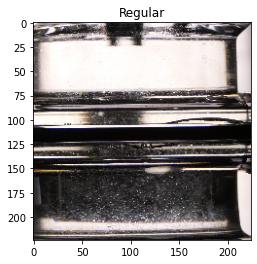

In [33]:
image = load_img('C:/Users/test/Regular_State/normalzustand007799.png', target_size=(224, 224))
plt.imshow(image)
plt.title('Regular')
plt.show()

In [34]:
image = img_to_array(image)
image = image.reshape((1, 224, 224, 3))
image = preprocess_input(image)

In [35]:
#pred = model.predict_classes(image)
pred = int(np.argmax(model.predict(image), axis=-1))
print('Predicted image is:', names[pred])
print('True label is: Regular_State')

Predicted image is: Regular_State
True label is: Regular_State
